# Block Model with a 1D background

### => Question 1: Should we make it VTI? Can all the codes handle VTI resistivity?

### => Question 2: Currently x-directed dipole, 200 m long. Could make that an arbitary rotated dipole - can all codes handle arbitrary rotated dipoles? 

### => Any suggestions to change the model somehow?

### Characteristics
- **Layered background** can be compared to 1D codes.
- **Simple blockmodel** as benchmark
- The blocks are an **adjusted version of the Dublin Test Model 1** (DTM1), Miensopust et al., 2013. Changes to the model include:
  - Added a layered background (instead of homogeneous background).
  - Converted to a shallow marine scenario, where the airwave is still dominantly present.
  - Layered background contains a weak, shallow resistor (e.g., tiny gas accumulations)
    and a deep strong resistor (e.g., basalt).
  - The blocks are made smaller in size (sort of MT to CSEM adaption):
      - all horizontal distances were divided by a factor of 5,
      - vertical distances by a factor of 20.
  
  
#### References
- Miensopust, M. P., P. Queralt, A. G. Jones, and the 3D MT modellers, 2013, Magnetotelluric 3-D inversion – a review of two successful workshops on forward and inversion code testing and comparison: Geophysical Journal International, 193, 1216–1238; DOI: [10.1093/gji/ggt066](https://doi.org/10.1093/gji/ggt066).

In [1]:
import emg3d         # 3D modeller emg3d
import empymod       # 1D modeller for comparison
import discretize    # for the meshing
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

In [2]:
%matplotlib notebook
plt.style.use('ggplot')

## «CSEM Test Model 1»

In [3]:
# Define all the required edges in x, y, and z-directions
hx, x0 = np.array([5500, 4000, 500, 500, 4000, 5500]), -10000
hy, y0 = np.array([6000, 1000, 3000, 3000, 1000, 6000]), -10000
hz, z0 = np.array([250, 50, 1250, 250, 750, 100, 50, 100, 600, 500]), -3400

# Initiate the mesh
mesh = discretize.TensorMesh([hx, hy, hz], x0=np.array([x0, y0, z0]))

# Extract the depths of the layers (extracted from mesh, to ensure they are equal)
depth = np.r_[mesh.vectorNz[1], mesh.vectorNz[-5:-1]][::-1]

print("x-edges:", mesh.vectorNx)
print("y-edges:", mesh.vectorNy)
print("z-edges:", mesh.vectorNz)  # Includes background layers and blocks!
print("depths :", depth)          # Only layers

x-edges: [-10000.  -4500.   -500.      0.    500.   4500.  10000.]
y-edges: [-10000.  -4000.  -3000.      0.   3000.   4000.  10000.]
z-edges: [-3400. -3150. -3100. -1850. -1600.  -850.  -750.  -700.  -600.     0.
   500.]
depths : [    0.  -600.  -700.  -750. -3150.]


In [4]:
# 1.A Initiate the resistivity model
res = np.zeros(mesh.nC)

# 1.B Define layered background model
res1d = [1e8, 0.3, 1, 5, 1, 1000]
res[mesh.gridCC[:, 2] > depth[0]] = res1d[0]     # Air
res[mesh.gridCC[:, 2] <= depth[0]] = res1d[1]    # Water
res[mesh.gridCC[:, 2] <= depth[1]] = res1d[2]    # Background
res[mesh.gridCC[:, 2] <= depth[-1]] = res1d[-1]  # Basement

# Add a shallow layer with slightly higher resistivities (5 Ohm.m)
res[(mesh.gridCC[:, 2] <= depth[2]) & (mesh.gridCC[:, 2] > depth[3])] = res1d[3]

# Store as background resistivity
res_bg = res.copy()

# 1.C Add the three blocks
resistivities = [10, 100, 500]  # Resistivities Block 1, 2, and 3
block1 = [ -500,  500, -4000, 4000,  -1600, -850]
block2 = [    0, 5000, -3000,    0,  -1850, -1600]
block3 = [-5000,    0,     0, 3000, -2900, -1600]
for i, block in enumerate([block1, block2, block3]):
    block_i = (
        (mesh.gridCC[:, 0] >= block[0]) & (mesh.gridCC[:, 0] <= block[1]) &
        (mesh.gridCC[:, 1] >= block[2]) & (mesh.gridCC[:, 1] <= block[3]) &
        (mesh.gridCC[:, 2] >= block[4]) & (mesh.gridCC[:, 2] <= block[5])
    )

    res[block_i] = resistivities[i]
    
# Reshape them
res = res.reshape(mesh.vnC, order='F')
res_bg = res_bg.reshape(mesh.vnC, order='F')

### Define survey

In [5]:
# Source: x-directed electric dipole of 200 m length, 50 meter above seafloor
src = [-100, 100, 0, 0, -550, -550]
strength = 800  # 800 A strength => 160 kAm source
freq = 1        # 1 Hz frequency

# 3 Receiver lines
rec_x = np.linspace(-10, 10, 101)*1e3
rec_y = np.array([-3, 0, 3])*1e3
rec_z = -600

<IPython.core.display.Javascript object>


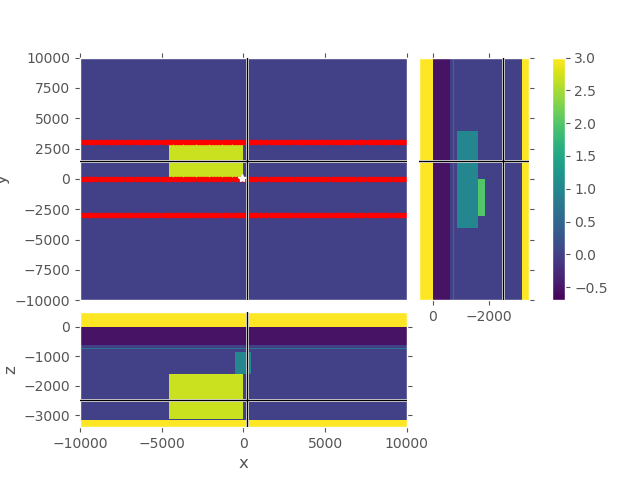

In [6]:
# Plot the resistivity model
mesh.plot_3d_slicer(np.log10(res), clim=np.log10([0.2, 1000]), zslice=-2500)
fig = plt.gcf()
axs = fig.get_children()[1]
axs.plot(rec_x, np.ones(rec_x.size)*rec_y[0], 'r.')
axs.plot(rec_x, np.ones(rec_x.size)*rec_y[1], 'r.')
axs.plot(rec_x, np.ones(rec_x.size)*rec_y[2], 'r.')
axs.plot(src[0], src[1], 'w*')
plt.show()

## 1D modelling of layered background

In [7]:
epm_1d = np.zeros((rec_x.size, 2), dtype=complex)
for i, y in enumerate(rec_y[:2]):
    epm_1d[:, i] = empymod.bipole(
        [*src[:4], -src[4], -src[5]],                   # empymod has
        [rec_x, np.ones(rec_x.size)*y, -rec_z, 0, 0],  # positive z
        -depth,                                         # downwards
        res1d, freq, srcpts=5, strength=strength,
        verb=2, htarg={'pts_per_dec': -1})


:: empymod END; runtime = 0:00:00.018931 :: 5 kernel call(s)

* WARNING :: Offsets < 0.001 m are set to 0.001 m!

:: empymod END; runtime = 0:00:00.048218 :: 5 kernel call(s)



<IPython.core.display.Javascript object>


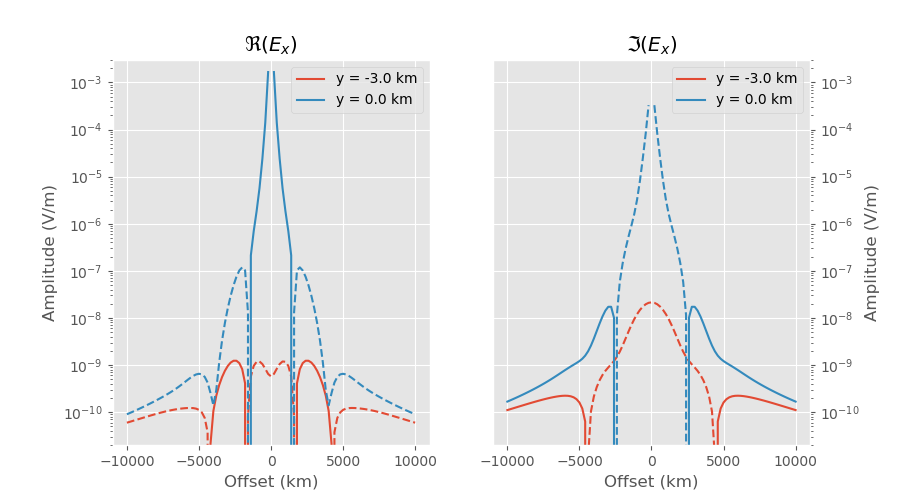

In [8]:
plt.figure(figsize=(9, 5))

# Real
ax1 = plt.subplot(121)
plt.title(r'$\Re(E_x)$')
for i, y in enumerate(rec_y[:2]):
    plt.plot(rec_x, epm_1d[:, i].real, f'C{i}-', label=f'y = {y/1e3} km')
    plt.plot(rec_x, -epm_1d[:, i].real, f'C{i}--')
    
plt.yscale('log')
plt.legend()
plt.xlabel('Offset (km)')
plt.ylabel('Amplitude (V/m)')

# Imaginary
ax2 = plt.subplot(122, sharey=ax1)
plt.title(r'$\Im(E_x)$')
for i, y in enumerate(rec_y[:2]):
    plt.plot(rec_x, epm_1d[:, i].imag, f'C{i}-', label=f'y = {y/1e3} km')
    plt.plot(rec_x, -epm_1d[:, i].imag, f'C{i}--')

plt.ylim([2e-11, 3e-3])
plt.legend()
plt.xlabel('Offset (km)')
plt.ylabel('Amplitude (V/m)')

ax2.yaxis.set_ticks_position('right')
ax2.yaxis.set_label_position('right')

plt.show()

## 3D modelling with emg3d, layered background

### 1. Create calculation mesh

For the background model, we could get away with a much coarser mesh. However, for simplicity we just use the same mesh for the background model and the full model.

Also, for the 1D model we only calculate the receiver lines for y=0 and y=-3 km, as the result for y=+/-3 km are identical.

In [9]:
# Get cell widths and origin in each direction
xx, x0 = emg3d.utils.get_hx_h0(
    freq=freq, res=[0.3, 1000], fixed=src[0], domain=[-3000, 3000], min_width=100)
yy, y0 = emg3d.utils.get_hx_h0(
    freq=freq, res=[0.3, 1000], fixed=src[1], domain=[-3000, 3000], min_width=100)
zz, z0 = emg3d.utils.get_hx_h0(
    freq=freq, res=[0.3, 100, 1000], fixed=rec_z, domain=[-3000, 0], min_width=50)

   Skin depth (m/l-r)  [m] : 276 / 15916
   Survey domain       [m] : -3000 - 3000
   Calculation domain  [m] : -98494 - 98494
   Final extent        [m] : -109656 - 109656
   Min/max cell width  [m] : 100 / 100 / 28905
   Alpha survey/calc       : 1.000 / 1.370
   Number of cells (s/c/r) : 96 (60/36/0)

   Skin depth (m/l-r)  [m] : 276 / 15916
   Survey domain       [m] : -3000 - 3000
   Calculation domain  [m] : -98494 - 98494
   Final extent        [m] : -109656 - 109656
   Min/max cell width  [m] : 100 / 100 / 28905
   Alpha survey/calc       : 1.000 / 1.370
   Number of cells (s/c/r) : 96 (60/36/0)

   Skin depth (m/l/r)  [m] : 276 / 5033 / 15916
   Survey domain       [m] : -3000 - 0
   Calculation domain  [m] : -33198 - 95494
   Final extent        [m] : -34233 - 113751
   Min/max cell width  [m] : 50 / 50 / 31373
   Alpha survey/calc       : 1.000 / 1.380
   Number of cells (s/c/r) : 96 (60/36/0)



In [10]:
# Create a TensorMesh instance.
mesh_3d = discretize.TensorMesh([xx, yy, zz], x0=[x0, y0, z0])
mesh_3d

TensorMesh: 884,736 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x     96   -109,655.67    109,655.67    100.00 28,904.82    1.37
   y     96   -109,655.67    109,655.67    100.00 28,904.82    1.37
   z     96    -34,232.97    113,750.81     50.00 31,372.69    1.38

In [11]:
# Interpolate to new mesh
cres_3d = 10**emg3d.utils.grid2grid(mesh, np.log10(res), mesh_3d, 'volume')
cres_3d_bg = 10**emg3d.utils.grid2grid(mesh, np.log10(res_bg), mesh_3d, 'volume')

# Create model
model_3d = emg3d.utils.Model(mesh_3d, cres_3d, freq=freq)
model_3d_bg = emg3d.utils.Model(mesh_3d, cres_3d_bg, freq=freq)

# QC background model
#mesh_3d.plot_3d_slicer(
#    np.log10(model_3d_bg.res_x), #zslice=-2000,
#    xlim=(-10000, 10000),
#    ylim=(-10000, 10000),
#    zlim=(-6000, 500),
#    clim=np.log10([0.2, 200])
#)

### 2. Background calculation

For the background, we only calculate the receiver lines for y=0 and y=-3 km, as the result for y=+/-3 km are identical.

In [12]:
# Source field
sfield_3d = emg3d.utils.get_source_field(mesh_3d, src, freq, strength=strength)

efield_3d_bg = emg3d.solver.solver(
    mesh_3d, model_3d_bg, sfield_3d,
    sslsolver=True,
    semicoarsening=True,
    linerelaxation=True,
    verb=3
)


:: emg3d START :: 10:13:13 ::

   MG-cycle       : 'F'                 sslsolver : 'bicgstab'
   semicoarsening : True [1 2 3]        tol       : 1e-06
   linerelaxation : True [4 5 6]        maxit     : 50 (3)
   nu_{i,1,c,2}   : 0, 2, 1, 2          verb      : 3
   Original grid  :  96 x  96 x  96     => 884,736 cells
   Coarsest grid  :   3 x   3 x   3     => 27 cells
   Coarsest level :   5 ;   5 ;   5   

   [hh:mm:ss]  rel. error            solver              MG          l s

       h_
      2h_ \                            /
      4h_  \                  /\      / 
      8h_   \          /\    /  \    /  
     16h_    \    /\  /  \  /    \  /   
     32h_     \/\/  \/    \/      \/    

   [10:13:29]   2.723e-03  after                       1 F-cycles    4 1
   [10:13:49]   1.768e-04  after                       2 F-cycles    5 2
   [10:14:03]   5.768e-05  after                       3 F-cycles    6 3
   [10:14:25]   4.311e-06  after                       4 F-cycles    4 1
   

In [13]:
# Extract (interpolate) Ex-field at receiver locations from the emg3d result.
egd_bg = np.zeros((rec_x.size, 2), dtype=complex)
for i, y in enumerate(rec_y[:2]):
    egd_bg[:, i] = emg3d.utils.get_receiver(mesh_3d, efield_3d_bg.fx, (rec_x, y, rec_z))

<IPython.core.display.Javascript object>


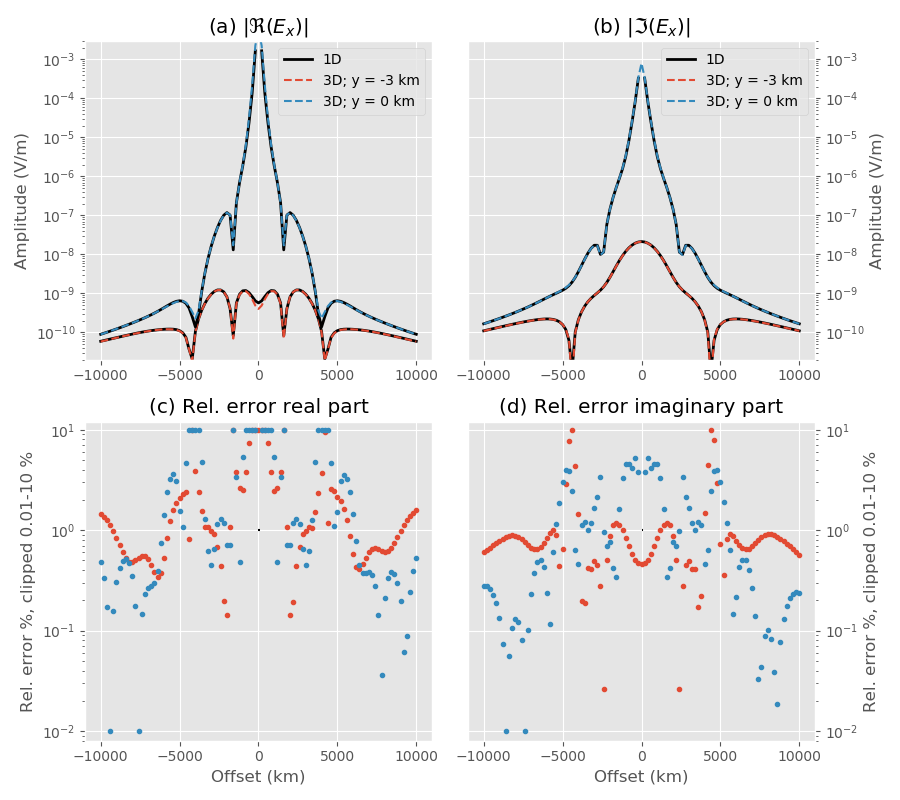

In [14]:
plt.figure(figsize=(9, 8))

# Real
ax1 = plt.subplot(221)
plt.title(r'(a) $|\Re(E_x)|$')
plt.plot(rec_x, abs(epm_1d[:, 0].real), f'k-', lw=2, label=f'1D')
plt.plot(rec_x, abs(egd_bg[:, 0].real), f'C0--', label=f'3D; y = {rec_y[0]/1e3:.0f} km')
plt.plot(rec_x, abs(epm_1d[:, 1].real), f'k-', lw=2)
plt.plot(rec_x, abs(egd_bg[:, 1].real), f'C1--', label=f'3D; y = {rec_y[1]/1e3:.0f} km')
    
plt.yscale('log')
plt.legend()
plt.ylabel('Amplitude (V/m)')

# Imaginary
ax2 = plt.subplot(222, sharey=ax1)
plt.title(r'(b) $|\Im(E_x)|$')

plt.plot(rec_x, abs(epm_1d[:, 0].imag), f'k-', lw=2, label=f'1D')
plt.plot(rec_x, abs(egd_bg[:, 0].imag), f'C0--', label=f'3D; y = {rec_y[0]/1e3:.0f} km')
plt.plot(rec_x, abs(epm_1d[:, 1].imag), f'k-', lw=2)
plt.plot(rec_x, abs(egd_bg[:, 1].imag), f'C1--', label=f'3D; y = {rec_y[1]/1e3:.0f} km')

plt.ylim([2e-11, 3e-3])
plt.legend()
plt.ylabel('Amplitude (V/m)')

ax2.yaxis.set_ticks_position('right')
ax2.yaxis.set_label_position('right')

# Real
ax3 = plt.subplot(223)
plt.title('(c) Rel. error real part')

# Calculate error
err = np.clip(100*abs((epm_1d.real-egd_bg.real)/epm_1d.real), 0.01, 10)

plt.plot(rec_x, err[:, 0], 'C0.')
plt.plot(rec_x, err[:, 1], 'C1.')
plt.yscale('log')
plt.hlines(1, 0, 100)
plt.xlabel('Offset (km)')
plt.ylabel('Rel. error %, clipped 0.01-10 %')
plt.ylim([0.008, 12])

# Imaginary
ax4 = plt.subplot(224, sharey=ax3)
plt.title('(d) Rel. error imaginary part')

# Calculate error
err = np.clip(100*abs((epm_1d.imag-egd_bg.imag)/epm_1d.imag), 0.01, 10)

plt.plot(rec_x, err[:, 0], 'C0.')
plt.plot(rec_x, err[:, 1], 'C1.')
plt.yscale('log')
plt.hlines(1, 0, 100)
plt.xlabel('Offset (km)')
plt.ylabel('Rel. error %, clipped 0.01-10 %')
plt.ylim([0.008, 12])

ax4.yaxis.set_ticks_position('right')
ax4.yaxis.set_label_position('right')

plt.tight_layout()
plt.show()

### 3. Full model calculation

In [15]:
# As we use the same mesh, it is the same source field.
efield_3d = emg3d.solver.solver(
    mesh_3d, model_3d, sfield_3d,
    sslsolver=True,
    semicoarsening=True,
    linerelaxation=True,
    verb=3
)


:: emg3d START :: 10:14:59 ::

   MG-cycle       : 'F'                 sslsolver : 'bicgstab'
   semicoarsening : True [1 2 3]        tol       : 1e-06
   linerelaxation : True [4 5 6]        maxit     : 50 (3)
   nu_{i,1,c,2}   : 0, 2, 1, 2          verb      : 3
   Original grid  :  96 x  96 x  96     => 884,736 cells
   Coarsest grid  :   3 x   3 x   3     => 27 cells
   Coarsest level :   5 ;   5 ;   5   

   [hh:mm:ss]  rel. error            solver              MG          l s

       h_
      2h_ \                            /
      4h_  \                  /\      / 
      8h_   \          /\    /  \    /  
     16h_    \    /\  /  \  /    \  /   
     32h_     \/\/  \/    \/      \/    

   [10:15:15]   2.497e-03  after                       1 F-cycles    4 1
   [10:15:29]   1.560e-04  after                       2 F-cycles    5 2
   [10:15:44]   6.801e-05  after                       3 F-cycles    6 3
   [10:15:59]   5.739e-06  after                       4 F-cycles    4 1
   

In [16]:
# Extract (interpolate) Ex-field at receiver locations from the emg3d result.
egd = np.zeros((rec_x.size, 3), dtype=complex)
for i, y in enumerate(rec_y):
    egd[:, i] = emg3d.utils.get_receiver(mesh_3d, efield_3d.fx, (rec_x, y, rec_z))

<IPython.core.display.Javascript object>


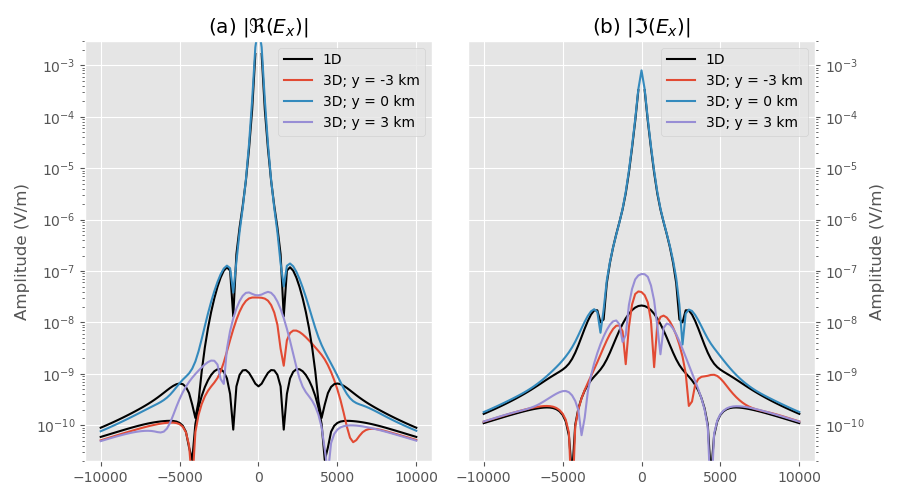

In [17]:
plt.figure(figsize=(9, 5))

# Real
ax1 = plt.subplot(121)
plt.title(r'(a) $|\Re(E_x)|$')

for i, y in enumerate(rec_y):
    if i < 1:
        plt.plot(rec_x, abs(epm_1d[:, i].real), f'k-', label=f'1D')
    elif i < 2:
        plt.plot(rec_x, abs(epm_1d[:, i].real), f'k-')
    plt.plot(rec_x, abs(egd[:, i].real), f'C{i}-', label=f'3D; y = {rec_y[i]/1e3:.0f} km')
    
plt.yscale('log')
plt.legend()
plt.ylabel('Amplitude (V/m)')

# Imaginary
ax2 = plt.subplot(122, sharey=ax1)
plt.title(r'(b) $|\Im(E_x)|$')

for i, y in enumerate(rec_y):
    if i < 1:
        plt.plot(rec_x, abs(epm_1d[:, i].imag), f'k-', label=f'1D')
    elif i < 2:
        plt.plot(rec_x, abs(epm_1d[:, i].imag), f'k-')
    plt.plot(rec_x, abs(egd[:, i].imag), f'C{i}-', label=f'3D; y = {rec_y[i]/1e3:.0f} km')

plt.ylim([2e-11, 3e-3])
plt.legend()
plt.ylabel('Amplitude (V/m)')

ax2.yaxis.set_ticks_position('right')
ax2.yaxis.set_label_position('right')

plt.tight_layout()
plt.show()

In [18]:
import pyvista
dataset = mesh.toVTK({'res': np.log10(res).ravel('F')})
p = pyvista.Plotter(notebook=False)

# Exclude the air layer
dataset = dataset.threshold(np.log10([0.3, 1e4]))

# Show blocks
p.add_mesh(dataset.threshold(np.log10([9, 501])))

# Show orthogonal slicer
p.add_mesh_slice_orthogonal(dataset)

p.show_grid()
p.show()

[(46638.81085509498, 46638.81085509498, 44938.81085509498),
 (0.0, 0.0, -1700.0),
 (0.0, 0.0, 1.0)]

In [19]:
empymod.Report([discretize])

--------------------------------------------------------------------------------
  Date: Mon Oct 21 10:17:26 2019 CEST

             Linux : OS
                 4 : CPU(s)
            x86_64 : Machine
             64bit : Architecture
           15.5 GB : RAM
           Jupyter : Environment

  Python 3.7.4 (default, Aug 13 2019, 20:35:49)  [GCC 7.3.0]

            0.4.10 : discretize
            1.17.2 : numpy
             1.3.1 : scipy
            1.10.0 : empymod
             2.7.0 : numexpr
             7.8.0 : IPython
             3.1.1 : matplotlib

  Intel(R) Math Kernel Library Version 2019.0.4 Product Build 20190411 for
  Intel(R) 64 architecture applications
--------------------------------------------------------------------------------